In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nanawest/time_series_US_20040101-0800_20260205-2340.csv


In [2]:
import os
import pandas as pd

# Check files in the folder
os.listdir("/kaggle/input/nanawest")


['time_series_US_20040101-0800_20260205-2340.csv']

In [3]:
file_path = "/kaggle/input/nanawest/time_series_US_20040101-0800_20260205-2340.csv"

df = pd.read_csv(file_path)

df.head()

,Time,Vivienne Westwood,Nana,chanel
0,2004-01-01,0,0,0
1,2004-02-01,0,0,0
2,2004-03-01,0,0,0
3,2004-04-01,1,1,0
4,2004-05-01,1,0,0


In [4]:
# Rename Time column
df = df.rename(columns={"Time": "date"})

# Convert to datetime
df["date"] = pd.to_datetime(df["date"])

# Sort (important for time series)
df = df.sort_values("date")

df.head()
df.count()

date                 265
Vivienne Westwood    265
Nana                 265
chanel               265
dtype: int64

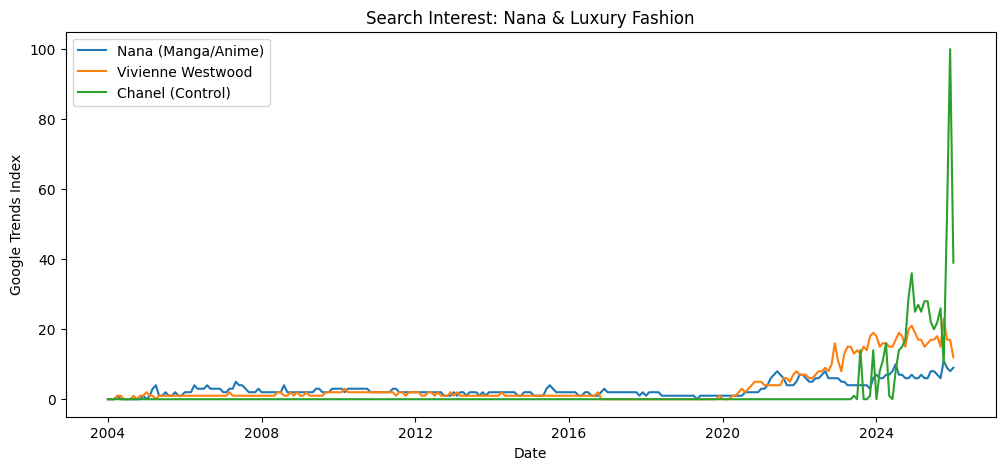

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(df["date"], df["Nana"], label="Nana (Manga/Anime)")
plt.plot(df["date"], df["Vivienne Westwood"], label="Vivienne Westwood")
plt.plot(df["date"], df["chanel"], label="Chanel (Control)")

plt.legend()
plt.title("Search Interest: Nana & Luxury Fashion")
plt.xlabel("Date")
plt.ylabel("Google Trends Index")
plt.show()


In [6]:
# Rename columns to short, clean names
df = df.rename(columns={
    "Nana": "nana",
    "Vivienne Westwood": "vw"
})

# Check result
df.columns


Index(['date', 'vw', 'nana', 'chanel'], dtype='object')

In [7]:
# 1) Create lagged Nana series (previous months)
df["nana_lag1"] = df["nana"].shift(1)  # 1 month earlier
df["nana_lag2"] = df["nana"].shift(2)  # 2 months earlier

# 2) Quick lead-lag correlation check (drop NaNs created by shifting)
corrs = df[["vw", "nana", "nana_lag1", "nana_lag2", "chanel"]].dropna().corr()

print(corrs.loc["vw", ["nana", "nana_lag1", "nana_lag2", "chanel"]])
print(corrs.loc["nana", ["vw", "chanel"]])

nana         0.812551
nana_lag1    0.796466
nana_lag2    0.794725
chanel       0.611963
Name: vw, dtype: float64
vw        0.812551
chanel    0.524471
Name: nana, dtype: float64


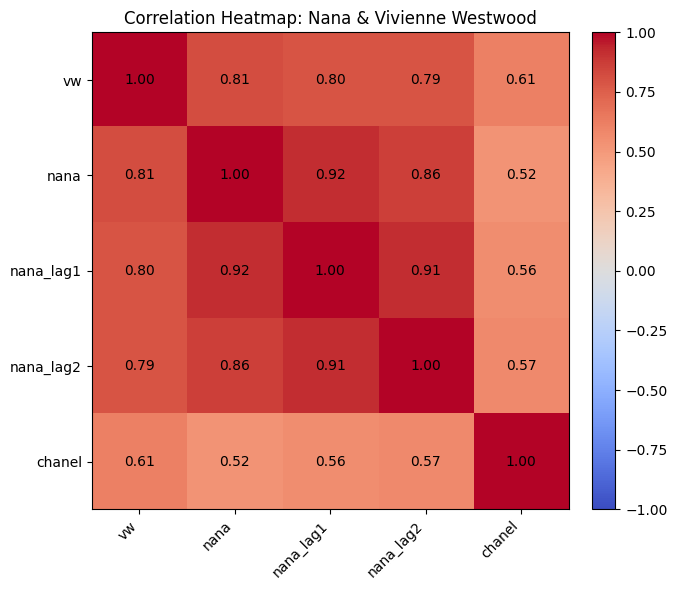

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Select relevant variables
corr_data = df[["vw", "nana", "nana_lag1", "nana_lag2", "chanel"]].dropna()

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(7,6))

im = plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)

# Add colorbar
plt.colorbar(im, fraction=0.046, pad=0.04)

# Add axis labels
labels = corr_matrix.columns

plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)

# Add correlation values on cells
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(
            j, i,
            f"{corr_matrix.iloc[i, j]:.2f}",
            ha="center",
            va="center",
            color="black"
        )

plt.title("Correlation Heatmap: Nana & Vivienne Westwood")
plt.tight_layout()
plt.show()


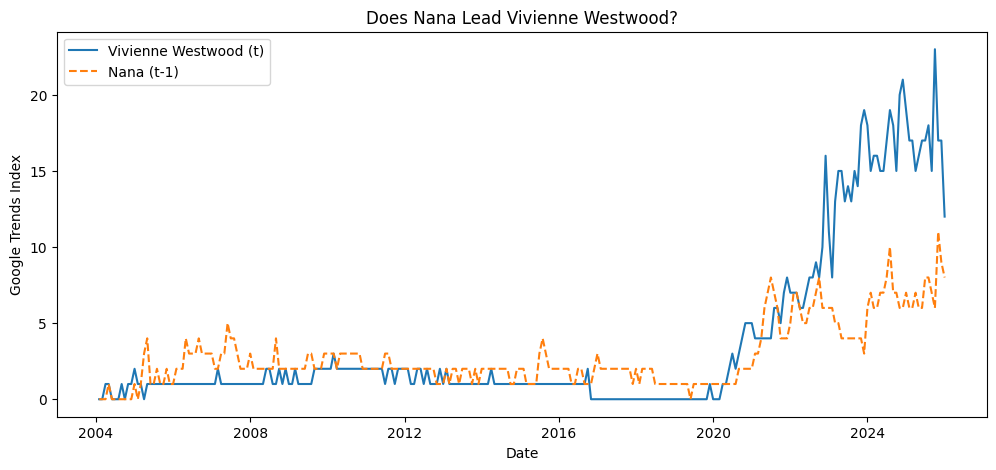

In [9]:
import matplotlib.pyplot as plt

# Drop rows with NaNs from lagging
plot_df = df.dropna(subset=["nana_lag1", "vw"])

plt.figure(figsize=(12,5))

plt.plot(plot_df["date"], plot_df["vw"], label="Vivienne Westwood (t)")
plt.plot(plot_df["date"], plot_df["nana_lag1"], label="Nana (t-1)", linestyle="--")

plt.legend()
plt.title("Does Nana Lead Vivienne Westwood?")
plt.xlabel("Date")
plt.ylabel("Google Trends Index")
plt.show()


In [10]:
import numpy as np

# Create time trend
df["trend"] = np.arange(len(df))

# Drop rows with NaNs (from lagging)
reg_df = df.dropna(subset=["vw", "nana_lag1", "chanel", "trend"])

# Select variables
reg_df[["date", "vw", "nana_lag1", "chanel", "trend"]].head()


,date,vw,nana_lag1,chanel,trend
1,2004-02-01,0,0.0,0,1
2,2004-03-01,0,0.0,0,2
3,2004-04-01,1,0.0,0,3
4,2004-05-01,1,1.0,0,4
5,2004-06-01,0,0.0,0,5


### Cultural Spillover Regression Model

We estimate the following model:

$$
VW_t = \alpha + \beta_1 \, Nana_{t-1} + \beta_2 \, Chanel_t + \beta_3 \, Trend_t + \varepsilon_t
$$

Where:

- $VW_t$ = Vivienne Westwood search interest at time $t$  
- $Nana_{t-1}$ = Nana search interest one month earlier  
- $Chanel_t$ = Chanel search interest (luxury market control)  
- $Trend_t$ = Linear time trend  
- $\beta_1$ = Cultural spillover effect from Nana to Westwood  
- $\varepsilon_t$ = Error term


In [11]:
import statsmodels.api as sm

# Define outcome
Y = reg_df["vw"]

# Define predictors
X = reg_df[["nana_lag1", "chanel", "trend"]]

# Add intercept
X = sm.add_constant(X)

# Fit regression with robust standard errors (for time series)
model = sm.OLS(Y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

# Show results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                     vw   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     39.37
Date:                Sun, 08 Feb 2026   Prob (F-statistic):           5.21e-21
Time:                        05:56:22   Log-Likelihood:                -649.72
No. Observations:                 264   AIC:                             1307.
Df Residuals:                     260   BIC:                             1322.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0943      0.685     -4.515      0.0

## Machine Learning Extension: Modeling Cultural Spillover

In addition to causal regression, we apply machine learning models to examine whether the relationship between *Nana* and Vivienne Westwood search interest is nonlinear and predictive.

### Objectives

The machine learning analysis aims to:

- Test whether the spillover effect is stable beyond linear assumptions  
- Identify potential threshold or saturation effects  
- Evaluate predictive power of cultural attention on brand demand  
- Complement causal inference with flexible models  

---

### Model Selection

Given the moderate sample size (approximately 260 observations), we focus on models suitable for small-to-medium time series data:

- **Gradient Boosting Regression** (primary model)  
- **Random Forest Regression** (robust baseline)  
- **Elastic Net Regression** (regularized linear benchmark)  

Deep learning models are avoided due to limited data and high overfitting risk.

---

### Feature Engineering

The following features are constructed:

| Feature | Description |
|---------|-------------|
| `nana_lag1`–`nana_lag3` | Lagged Nana search interest (1–3 months) |
| `vw_lag1` | Lagged Vivienne Westwood interest |
| `chanel` | Control for luxury market trends |
| `trend` | Linear time trend |

These variables capture cultural momentum, brand persistence, and market conditions.

---

### Training and Validation Strategy

Standard random train–test splitting is inappropriate for time series data.  
Instead, we use a chronological split:

- Training set: early period  
- Test set: later period  

This ensures that models are evaluated on future observations only, preventing information leakage.

---

### Evaluation Metrics

Model performance is assessed using:

- Root Mean Squared Error (RMSE)  
- Mean Absolute Error (MAE)  
- Out-of-sample R²  

These metrics measure forecasting accuracy and robustness.

---

### Interpretation and Explainability

To maintain interpretability:

- Feature importance is examined for tree-based models  
- SHAP values are used (when applicable) to assess variable contributions  

This ensures that predictions can be linked back to cultural and branding mechanisms.

---

### Limitations

The machine learning analysis is subject to several limitations:

- Limited sample size  
- Potential residual autocorrelation  
- Reliance on Google Trends as a proxy for consumer attention  

Therefore, ML results are interpreted as complementary to causal estimates rather than definitive evidence.

---

### Summary

Machine learning models are used to:

- Validate causal findings  
- Detect nonlinear spillover patterns  
- Improve predictive understanding  

They support, rather than replace, the primary causal analysis.


In [12]:
# Create more lags for ML
df["nana_lag3"] = df["nana"].shift(3)
df["vw_lag1"] = df["vw"].shift(1)   # past VW (for forecasting)

# Build ML dataset
ml_df = df[[
    "vw",
    "nana_lag1",
    "nana_lag2",
    "nana_lag3",
    "chanel",
    "trend",
    "vw_lag1"
]].dropna()

ml_df.head()


,vw,nana_lag1,nana_lag2,nana_lag3,chanel,trend,vw_lag1
3,1,0.0,0.0,0.0,0,3,0.0
4,1,1.0,0.0,0.0,0,4,1.0
5,0,0.0,1.0,0.0,0,5,1.0
6,0,0.0,0.0,1.0,0,6,0.0
7,0,0.0,0.0,0.0,0,7,0.0


In [13]:
# Separate features (X) and target (y)
X = ml_df.drop(columns=["vw"])
y = ml_df["vw"]

# Time-based split (80% train, 20% test)
split_idx = int(len(ml_df) * 0.8)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

# Check sizes
len(X_train), len(X_test)


(209, 53)